# Lab 2

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from random import randrange as rand

im_lena = np.array(Image.open("Images_TP/Lena.jpg"))
im_noise = np.array(Image.open("Images_TP/noise.tif"))
im_clown = np.array(Image.open("Images_TP/clown.tif"))
im_noisy_lena = np.array(Image.open("Images_TP/noisy_Lena.png"))
im_mercury = np.array(Image.open("Images_TP/mercury.tif"))

# Image.fromarray(im_dungeon).show()
def show2(im_ref,im,cmap= 'viridis',cmap_ref='viridis',title1='Before',title2='After'):
    f, axarr = plt.subplots(1,2)    #subplot(r,c) -> r:nb_rows, c:nb_columns
    axarr[0].set_title(title1)
    axarr[0].imshow(im_ref,cmap=cmap_ref)
    axarr[1].set_title(title2)
    axarr[1].imshow(im,cmap=cmap)
    f.set_figheight(9)
    f.set_figwidth(9)

def show3(im_ref,im1, im2,cmap= 'viridis',cmap_ref='viridis',title1='Step 1',title2='Step 2'):
    f, axarr = plt.subplots(1,3)    #subplot(r,c) -> r:nb_rows, c:nb_columns
    axarr[0].set_title('Original')
    axarr[0].imshow(im_ref,cmap=cmap_ref)
    axarr[1].set_title(title1)
    axarr[1].imshow(im1,cmap=cmap)
    axarr[2].set_title(title2)
    axarr[2].imshow(im2,cmap=cmap)
    f.set_figheight(10)
    f.set_figwidth(10)

def normalize(im):
    img = np.copy(im)
    img_max = np.max(img)
    img_min = np.min(img)
    img = 255 * ((img-img_min)/(img_max-img_min))
    return img


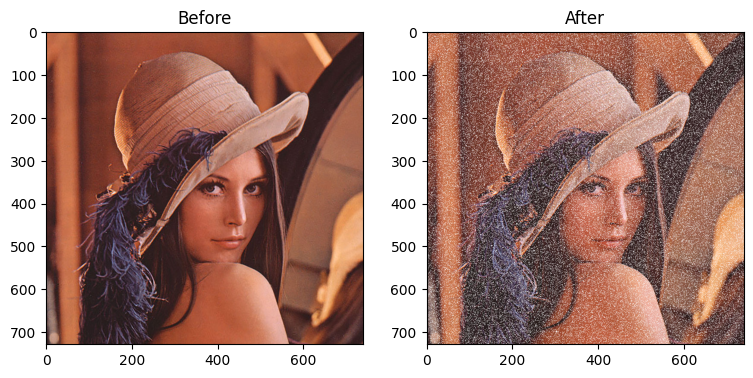

In [51]:
def add_noise(im,size=1,ratio=1/6):
    #ratio : nb de pixels bruités par pixels de l'image
    img = im[:,:,(0,1,2)]
    nb_alea = int((im.shape[0] * im.shape[1])*(ratio/size**2))
    for _ in range(0,nb_alea):
        x = rand(0,im.shape[0])
        y = rand(0,im.shape[1])
        noise = [[[255]*3]*size]*size
        if img[x:x+size,y:y+size].shape == (size,size,3):
            img[x:x+size,y:y+size] = noise
    return img

im_noisy_lena2 = add_noise(im_lena,1)
show2(im_lena,im_noisy_lena2)

## 1.  Le filtre médian, un filtre non-linéaire

La technique de filtre médian est largement utilisée en 
traitement d'images numériques, car elle permet de réduire le bruit tout en conservant les contours de 
l'image. L'idée principale du filtre médian est de remplacer chaque pixel par la valeur médiane de son 
voisinage.\
Le filtre médian va d'abord trier ces valeurs par ordre croissant, et prendre la valeur médiane.

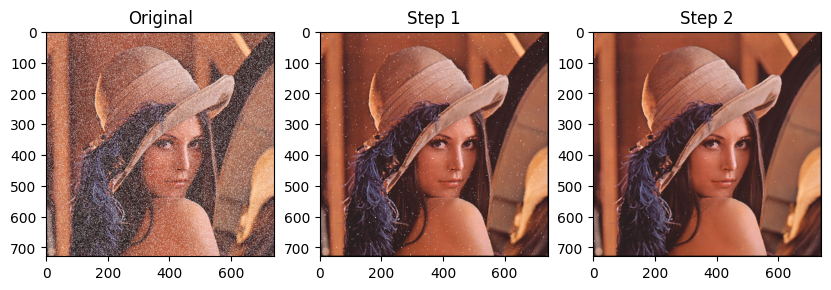

In [ ]:
def median_filter_RGB(im,size_filtre):
    #size_filtre : nb de pixels sur un côté
    height, width, nb_channels = im.shape
    assert(nb_channels < 4)        #besoin image RGB
    assert(size_filtre%2 == 1)      #filtre de taille impaire
    bord = size_filtre//2
    img = np.zeros_like(im)
    for y in range(bord,height-bord):
        for x in range(bord,width-bord):
            for c in range(0,nb_channels):
                input = im[y-bord:y+bord+1,x-bord:x+bord+1,c]
                img[y,x,c] = np.median(input,axis=None)
    return img

im_temp = median_filter_RGB(im_noisy_lena2,3)
im_temp2 = median_filter_RGB(im_temp,3)
show3(im_noisy_lena2,im_temp,im_temp2)

Plusieurs passages du filtre permet d'enlever (presque) tout le bruit.\
Un grain de bruit plus gros nécessite un filtre médian plus large, mais réduit la qualité de l'image (lissage)

## 2. Filtrage bruit périodique

In [168]:
def specral_imageGray(im):
    #applique la transformée de fourier (FFT) sur l'image im
    img = np.fft.fft2(im)
    return np.fft.fftshift(img) #centre la fondamentale

def view_spectral(im):
    #prépare l'image spectrale pour la visualiser
    return np.log(abs(im))

def imageGrey_from_spectral(im):
    #reconstruit l'image à partir de l'image de base
    reconstructed = abs(np.fft.ifft2(im))
    return normalize(reconstructed).astype(np.uint8)    #certaines valeurs dépassent 255

def symetrical_star_mask(im,masks):
    #construit un masque composé d'étoiles avec une symétrie centrale
    # masks : liste d'étoiles (centre,size,width)
    mask = abs(np.zeros_like(im)).astype(np.uint8)
    y_center = im.shape[0]//2
    x_center = im.shape[1]//2
    for (y,x,size,width) in masks :
        if size != width :
            mask[y-size:y+size,x-width:x+width] = 1
            mask[-y-size:-y+size,-x-width:-x+width] = 1
            mask[y-width:y+width,x-size:x+size] = 1
            mask[-y-width:-y+width,-x-size:-x+size] = 1
        else:
            mask[y-size:y+size,x-size:x+size] = 1
            mask[-y-size:-y+size,-x-size:-x+size] = 1
    return 1-mask

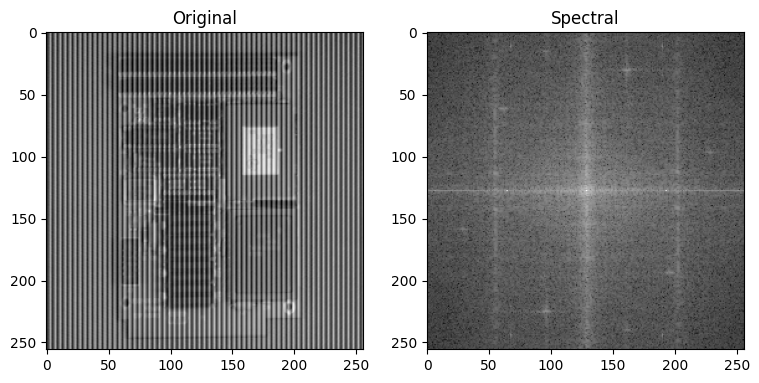

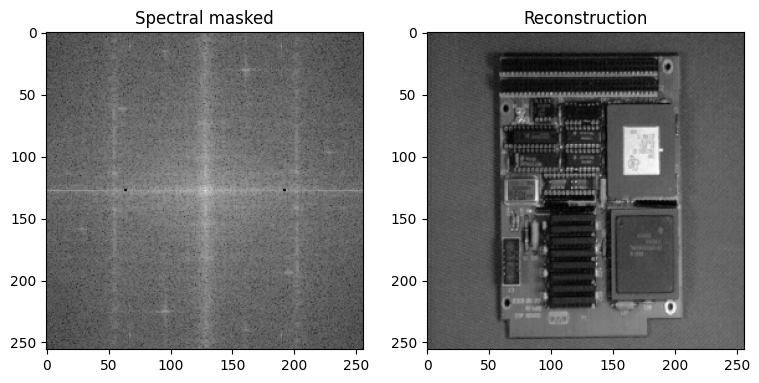

In [169]:
im_temp = specral_imageGray(im_noise)
show2(im_noise,view_spectral(im_temp),cmap='grey',cmap_ref='grey',
      title1='Original',title2='Spectral')

y = im_noise.shape[0]//2
mask = symetrical_star_mask(im_temp,[(y,64,1,1)])
im_temp2 = im_temp * mask    #applique le masque
im_temp2 = imageGrey_from_spectral(im_temp2)

show2(view_spectral(im_temp)*mask,im_temp2,cmap='grey',cmap_ref='grey',
      title1='Spectral masked',title2='Reconstruction')

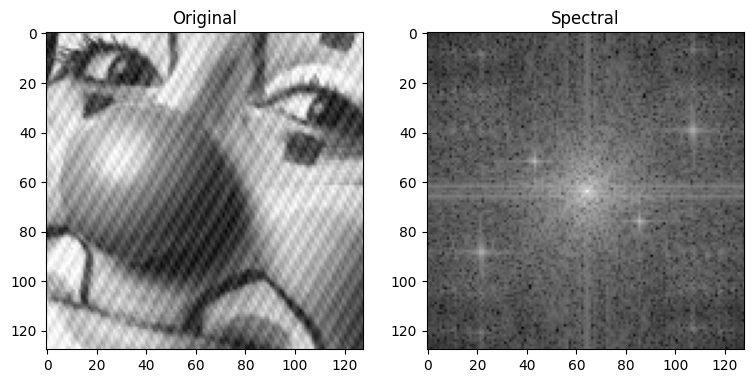

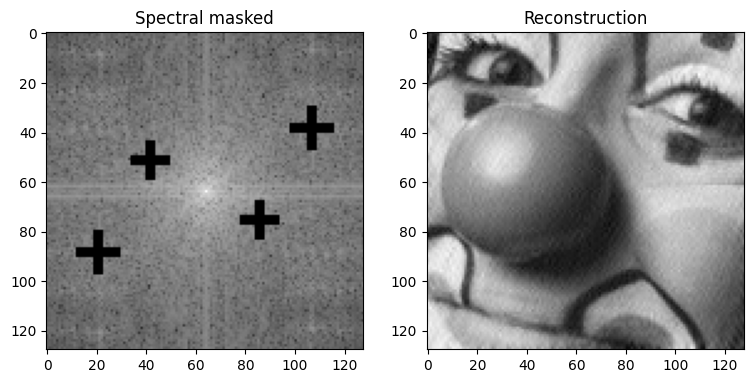

In [170]:
im_temp = specral_imageGray(im_clown)
show2(im_clown,view_spectral(im_temp),cmap='grey',cmap_ref='grey',
      title1='Original',title2='Spectral')

mask = symetrical_star_mask(im_temp,[(89,21,9,2),(52,42,8,2)])
im_temp2 = im_temp * mask    #applique le masque
im_temp2 = imageGrey_from_spectral(im_temp2)

show2(view_spectral(im_temp)*mask,im_temp2,cmap='grey',cmap_ref='grey',
      title1='Spectral masked',title2='Reconstruction')

## 3. Noise reduction